In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import keras.utils as image
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from sklearn.metrics import matthews_corrcoef
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
train_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/train'
test_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/test'

In [3]:
image_size=(224,224,3)

In [4]:
def load_images(directory):
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):  # Check if it's a directory
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)

In [5]:
# Load training and test images
train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)

# Preprocess images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


In [6]:
train_images.shape

(7459, 224, 224, 3)

In [8]:
# Load MobileNet with pre-trained weights on ImageNet
base_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224,3), pooling='None')

# Add Global Average Pooling (GAP) layer
x = base_mobilenet.output
x = GlobalAveragePooling2D()(x)

# Create the model
mobilenet_with_gap = Model(inputs=base_mobilenet.input, outputs=x)

2024-03-25 18:46:48.213223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 864 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:88:00.0, compute capability: 8.0
2024-03-25 18:46:48.217265: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7381 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:89:00.0, compute capability: 8.0
2024-03-25 18:46:48.221105: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 37953 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0
2024-03-25 18:46:48.224155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 37953 MB memory:  -> device: 3, name: NVIDIA A100-PCIE-40GB, pci bus i

In [9]:
# Function to extract features in batches
def extract_features(model, images, batch_size):
    num_images = images.shape[0]
    features = []
    for start_idx in range(0, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        batch = images[start_idx:end_idx]
        batch_features = model.predict(batch)
        features.append(batch_features)
    return np.concatenate(features)

In [10]:
# Extract features using the model without the top layer in batches
batch_size = 8  # Adjust based on GPU memory
train_features = extract_features(mobilenet_with_gap, train_images, batch_size)
test_features = extract_features(mobilenet_with_gap, test_images, batch_size)

2024-03-25 18:46:49.957278: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-25 18:46:50.071885: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1/1 [==============================] - 0s 433ms/step


In [11]:
test_features[0]

array([0.05328356, 1.0171133 , 0.04041292, ..., 2.8537385 , 0.        ,
       0.03074817], dtype=float32)

In [12]:
# # Define the parameter grid
# param_grid = {'n_neighbors': [8], 'metric': ['minkowski']}
# Define the parameter grid for KNN
knn_param_grid = {'n_neighbors' : range(2,15),
               'metric' : ['minkowski','euclidean','manhattan']}

# Create a KNN classifier
knn_classifier = KNeighborsClassifier()

# Use GridSearchCV to find the best parameters for KNN
grid_search = GridSearchCV(knn_classifier, knn_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_features, train_labels)

# Get the best parameters
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_metric = grid_search.best_params_['metric']


In [13]:
# Use the best parameters to train the final model
final_knn_classifier = KNeighborsClassifier(n_neighbors=best_n_neighbors, metric=best_metric)
start_time = time.time()
final_knn_classifier.fit(train_features, train_labels)
train_time = time.time() - start_time

# Predict labels for the test set
knn_predictions = final_knn_classifier.predict(test_features)

# Evaluate accuracy
knn_accuracy = accuracy_score(test_labels, knn_predictions)
print("Best KNN Parameters:", grid_search.best_params_)
print("Best KNN Accuracy:", knn_accuracy)

# Additional evaluation metrics
precision = precision_score(test_labels, knn_predictions, average='weighted')
recall = recall_score(test_labels, knn_predictions, average='weighted')
f1 = f1_score(test_labels, knn_predictions, average='weighted')


print("Train Time (sec):", train_time)
# If you used GridSearchCV, you can access the training time with `cv_results_`
grid_train_time = grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]
print("Train Time (sec) Grid:", grid_train_time)

Best KNN Parameters: {'metric': 'minkowski', 'n_neighbors': 3}
Best KNN Accuracy: 0.9853709508881923
Train Time (sec): 0.008370161056518555
Train Time (sec) Grid: 0.03445283571879069


In [14]:
# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(test_labels, knn_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Matthews Correlation Coefficient (MCC): 0.9829872469302405


In [15]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels, knn_predictions)
precision = precision_score(test_labels, knn_predictions, average='weighted')

FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# False omission rate
FOR_ = FN/(FN+TN)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [16]:
# Compute True Positive Rate (TPR), True Negative Rate (TNR), False Positive Rate (FPR)

# Display results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("True Positive Rate (TPR):", np.mean(TPR))
print("True Negative Rate (TNR):", np.mean(TNR))
print("False Positive Rate (FPR):", np.mean(FPR))
print("False Negative Rate (FNR):", np.mean(FNR))
print("False Discovery Rate (FDR):", np.mean(FDR))
print("False Omission Rate (FOR):", np.mean(FOR_))
print("Overall accuracy (ACC):",np.mean(ACC))


Precision: 0.9865610701614269
Recall: 0.9853709508881923
F1 Score: 0.985418769279283
True Positive Rate (TPR): 0.9641505791505791
True Negative Rate (TNR): 0.9994021435078725
False Positive Rate (FPR): 0.0005978564921275361
False Negative Rate (FNR): 0.035849420849420846
False Discovery Rate (FDR): 0.03218180670013577
False Omission Rate (FOR): 0.0006115881076349033
Overall accuracy (ACC): 0.9988296760710554


In [17]:
#Feature space (number of pixels in each image)
feature_space = train_images.shape
print("Feature Space:", feature_space)

# Accuracy for optimization algorithm (GridSearchCV)
optimization_accuracy = grid_search.best_score_
print("Optimization Algorithm Accuracy:", optimization_accuracy)


Feature Space: (7459, 224, 224, 3)
Optimization Algorithm Accuracy: 0.9789520685898666


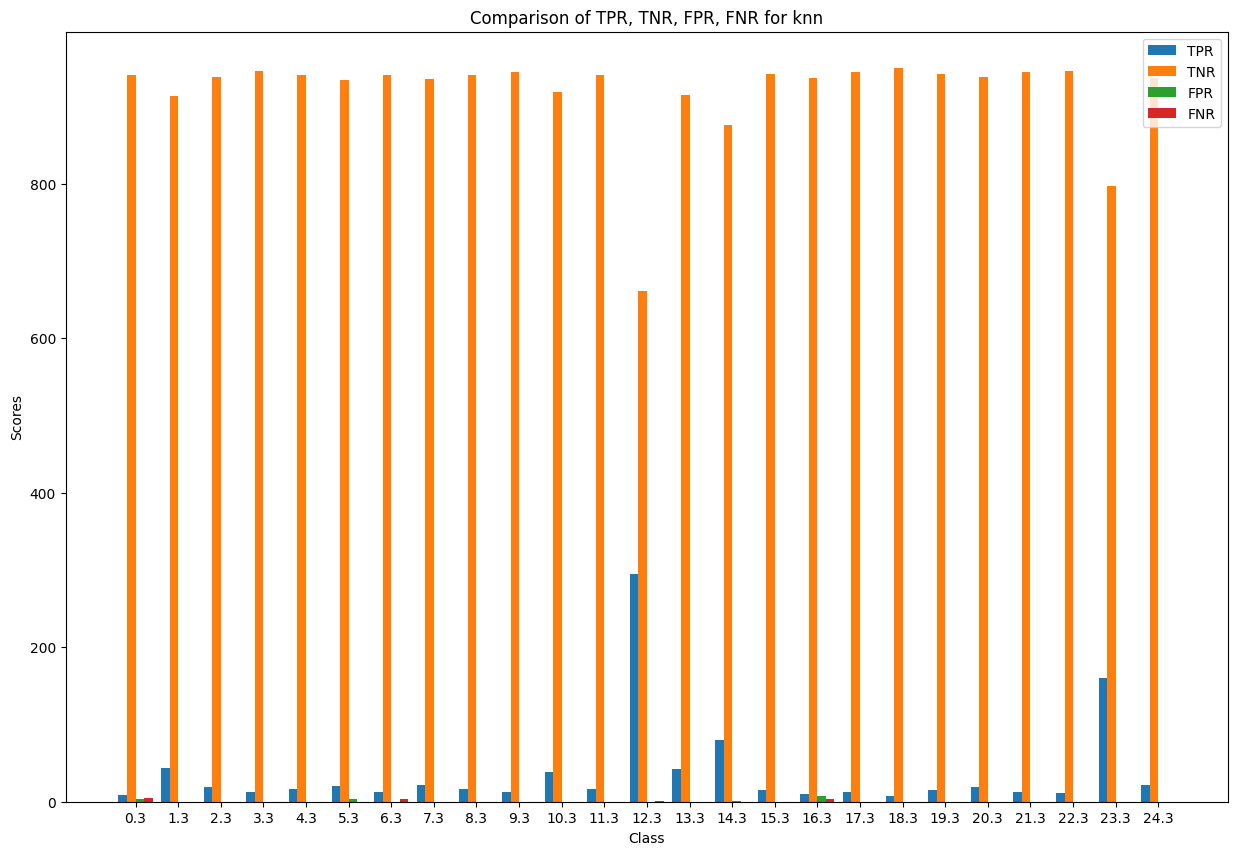

In [18]:
# Plot TPR, TNR, FPR, FNR
fig, ax = plt.subplots(figsize=(15, 10))

bar_width = 0.2
index = np.arange(25)  # Assuming you have 25 classes, adjust this based on your data

bar1 = ax.bar(index, TP, bar_width, label='TPR')
bar2 = ax.bar(index + bar_width, TN, bar_width, label='TNR')
bar3 = ax.bar(index + 2 * bar_width, FP, bar_width, label='FPR')
bar4 = ax.bar(index + 3 * bar_width, FN, bar_width, label='FNR')

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Comparison of TPR, TNR, FPR, FNR for knn')
ax.set_xticks(index + 1.5 * bar_width)
ax.legend()

plt.show()

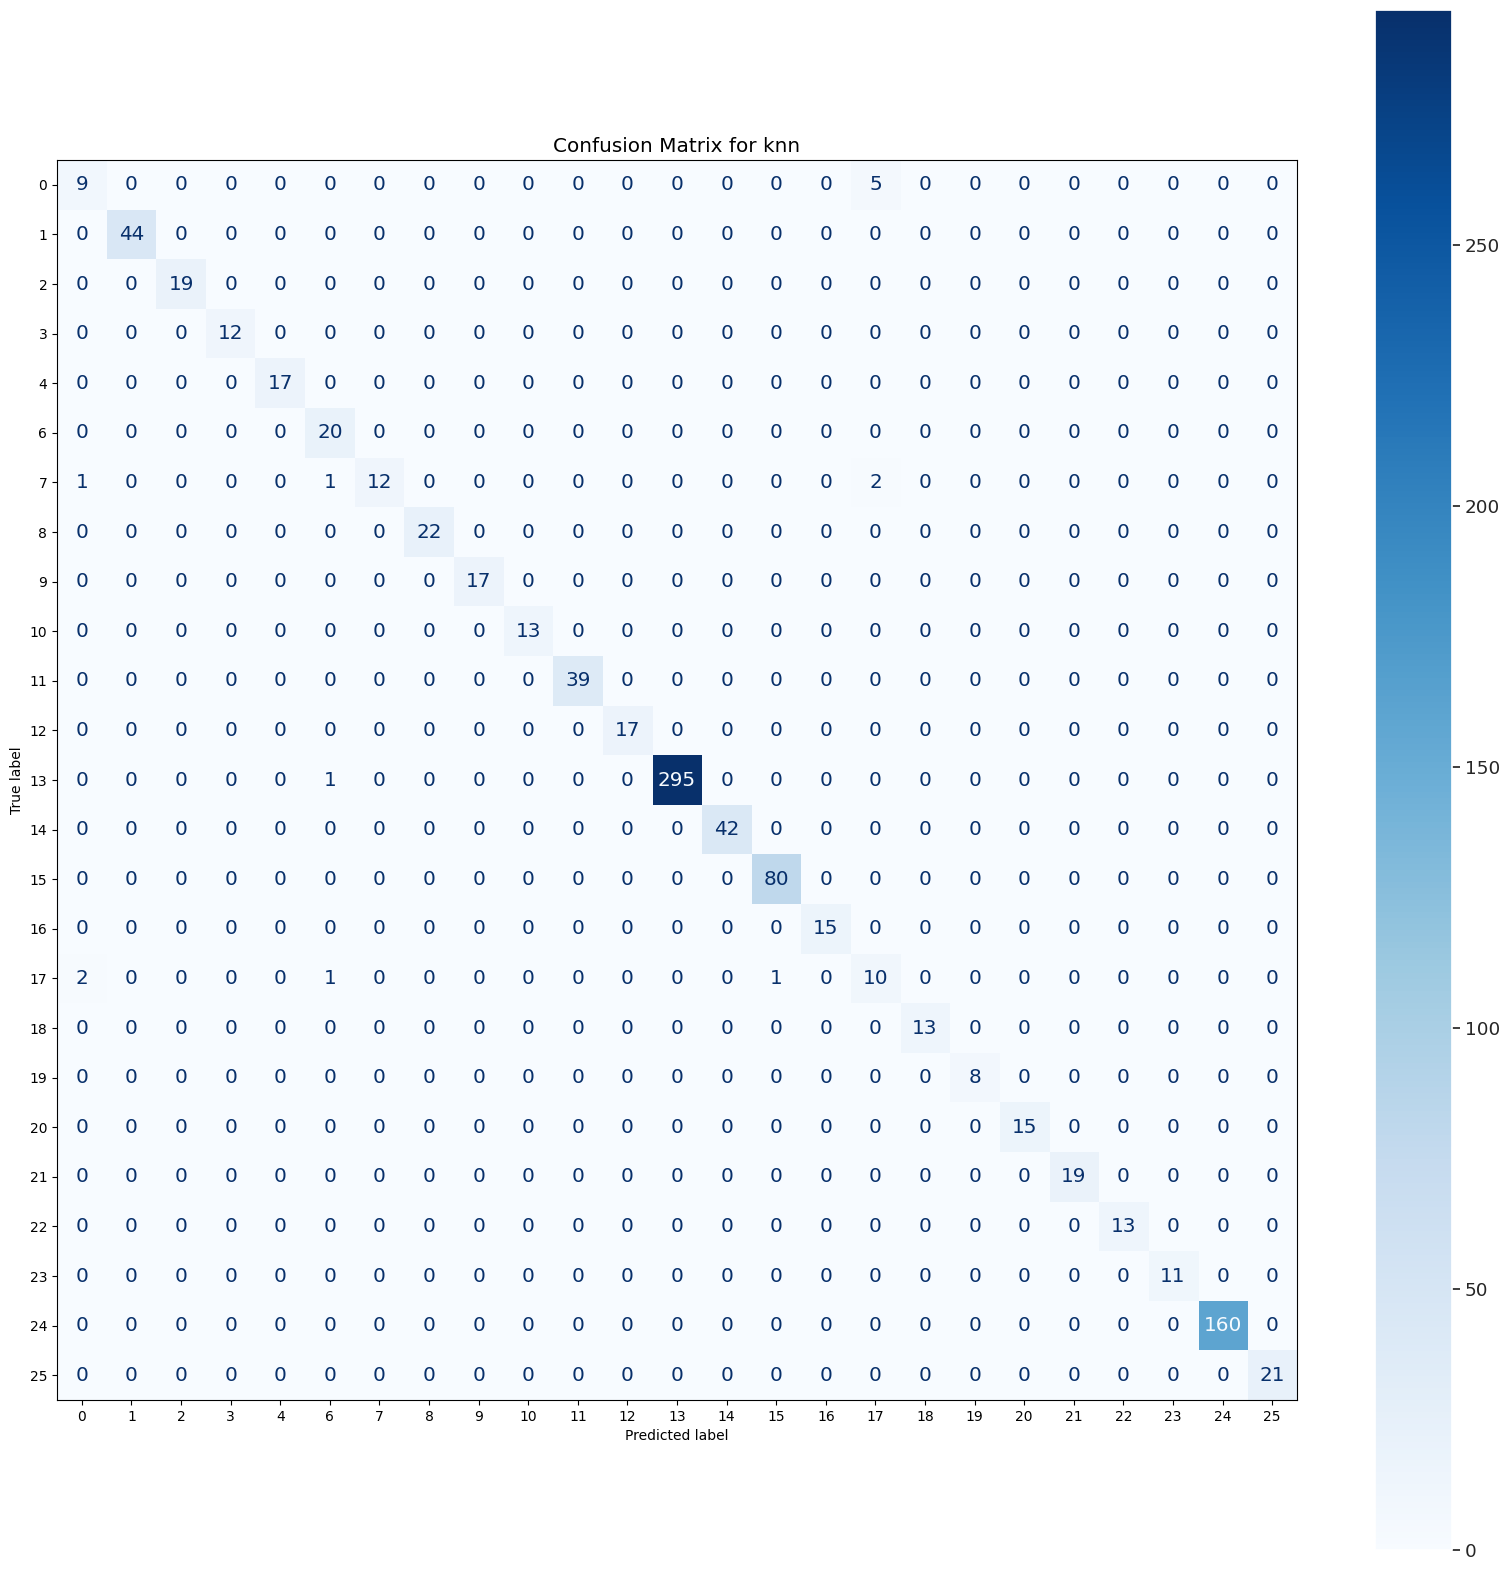

In [19]:
# Plot Confusion Matrix for Naive Bayes
fig, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.2)  # Adjust font size for better readability
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(test_labels))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix for knn')
plt.show()